# Medical Domain-Specific Chatbot Using Transformer Models

This notebook demonstrates the development of a domain-specific chatbot tailored for the medical field. The goal is to build a chatbot that understands medical-related user queries and generates accurate, relevant responses within this specialized domain.

We leverage the **T5 (Text-to-Text Transfer Transformer)** model, a powerful pre-trained transformer designed to handle a wide variety of natural language tasks by converting them into a unified text-to-text format. T5 is well-suited for generative question answering, enabling the chatbot to produce coherent free-text answers to medical questions.

The dataset used contains conversational pairs from the medical domain, preprocessed and fine-tuned using Hugging Face's `transformers` library (version 4.57.0) and TensorFlow/PyTorch APIs. This process encompasses tokenization, data cleaning, fine-tuning hyperparameter tuning, and performance evaluation using metrics like BLEU and F1-score.

The final chatbot is deployed using **Gradio**, providing an intuitive web interface for interactive medical question answering.

This project demonstrates practical skills in:
- Fine-tuning transformer models on domain-specific datasets
- Building NLP pipelines including preprocessing and tokenization
- Evaluating chatbot performance quantitatively and qualitatively
- Deploying AI-powered chatbots with user-friendly interfaces

The notebook is designed to run with GPU acceleration for efficient training, particularly on platforms like Google Colab.

---


Setup and GPU Check

In [54]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("GPU is available. Using GPU.")
else:
    print("GPU not available. Switch runtime to GPU for better performance.")


GPU is available. Using GPU.


Install Required Libraries

In [84]:
!pip install --upgrade transformers


Import Libraries

In [56]:
pip install evaluate


In [80]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset
from transformers import TFAutoModelForSeq2SeqLM

import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.optim import AdamW



Load Dataset

In [58]:
df = pd.read_csv('medical.csv')


# Display first few rows
print("Sample data:")
print(df.head())


Sample data:
                                     question  \
0       What are simple ways to stay healthy?   
1  Why is sleep important for health? please?   
2         What is a healthy body temperature?   
3   How often should I get a general checkup?   
4           How often should I wash my hands?   

                                              answer            tags  
0  See a doctor if symptoms are persistent, worse...  general_health  
1  Eat varied foods, stay active, sleep well, and...  general_health  
2  Wash your hands before eating, after using the...  general_health  
3  Balanced meals include protein, healthy fats, ...  general_health  
4  Normal body temperature is about 36–37.5°C (97...  general_health  


Dataset Info, Nulls, and Duplicates Check

In [59]:
# Overview of dataset structure and null values
print("\nDataset info:")
print(df.info())

print("\nNull values per column:")
print(df.isnull().sum())

# Count duplicate rows
duplicates_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5000 non-null   object
 1   answer    5000 non-null   object
 2   tags      5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB
None

Null values per column:
question    0
answer      0
tags        0
dtype: int64

Number of duplicate rows: 0


Visualize Question Length Distribution Before Cleaning

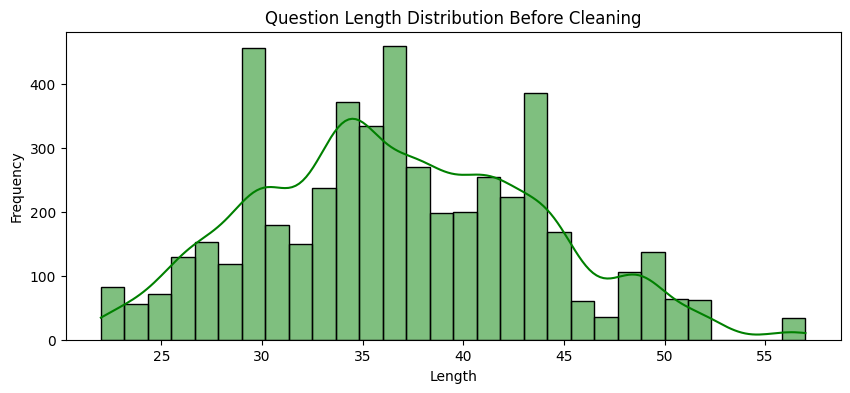

In [60]:
# Add question length column
df['question_length'] = df['question'].str.len()

# Plot distribution
plt.figure(figsize=(10,4))
sns.histplot(df['question_length'], bins=30, kde=True ,color='green')
plt.title("Question Length Distribution Before Cleaning")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


Data Cleaning

In [61]:
# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
print(f"Shape after duplicates removed: {df.shape}")

# Remove rows with null values
df = df.dropna().reset_index(drop=True)
print(f"Shape after nulls removed: {df.shape}")

# Normalize text to lowercase for consistency
df['question'] = df['question'].str.lower()
df['answer'] = df['answer'].str.lower()


Shape after duplicates removed: (5000, 4)
Shape after nulls removed: (5000, 4)


Train-Validation Split (Ordered)

In [62]:
# Split dataset into train (80%) and validation (20%) using ordered split for reproducibility
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].reset_index(drop=True)
val_df = df.iloc[train_size:].reset_index(drop=True)

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")


Training set shape: (4000, 4)
Validation set shape: (1000, 4)


In [63]:
train_df.to_csv("medical_chatbot_train.csv", index=False)
val_df.to_csv("medical_chatbot_validation.csv", index=False)


Tokenizer Initialization

In [64]:
from transformers import AutoTokenizer

# Initialize tokenizer (using T5-base for example)
model_name = 't5-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_input_length = 128


Preprocessing Function

In [65]:
def preprocess_function(examples):
    inputs = examples['question']
    targets = examples['answer']
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')

    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs


Create TensorFlow Dataset

In [66]:
import tensorflow as tf

max_input_length = 128
max_target_length = 128

def df_to_tf_dataset(df, shuffle=True, batch_size=16):
    inputs = df['question'].tolist()
    targets = df['answer'].tolist()

    encodings = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length', return_tensors='tf')
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding='max_length', return_tensors='tf')

    # Optional: ignore loss on padding tokens
    labels_input_ids = tf.where(labels['input_ids'] == tokenizer.pad_token_id, -100, labels['input_ids'])

    dataset = tf.data.Dataset.from_tensor_slices((
        dict(input_ids=encodings['input_ids'], attention_mask=encodings['attention_mask']),
        labels_input_ids
    ))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

batch_size = 16
train_dataset = df_to_tf_dataset(train_df, shuffle=True, batch_size=batch_size)
val_dataset = df_to_tf_dataset(val_df, shuffle=False, batch_size=batch_size)


Load Pretrained Model

In [81]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [ ]:
import transformers
print(transformers.__version__)


Train Model

In [85]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Ensure GPU is used if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and tokenizer
model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Convert Pandas DataFrame to Hugging Face Dataset (for train and val)
train_hf_dataset = Dataset.from_pandas(train_df)
val_hf_dataset = Dataset.from_pandas(val_df)

# Preprocessing function to tokenize questions and answers
def preprocess_function(examples):
    inputs = examples['question']
    targets = examples['answer']
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize the datasets
train_dataset = train_hf_dataset.map(preprocess_function, batched=True)
val_dataset = val_hf_dataset.map(preprocess_function, batched=True)

# Remove columns except model inputs
train_dataset = train_dataset.remove_columns(['question', 'answer'])
val_dataset = val_dataset.remove_columns(['question', 'answer'])

# Set format for PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments setup
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

# Define compute_metrics if you want evaluation metrics (e.g. BLEU) here or skip for simple loss monitoring

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Start training
trainer.train()


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Evaluate Performance

In [ ]:
import math

def calculate_perplexity(loss):
    return math.exp(loss)

print(f"Train Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Validation Perplexity: {calculate_perplexity(history.history['val_loss'][-1]):.4f}")


 Interactive Chatbot Testing

In [ ]:
def generate_answer(question):
    input_ids = tokenizer.encode(question, return_tensors='tf', max_length=max_input_length, truncation=True)
    outputs = model.generate(input_ids, max_length=max_target_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Simple loop to interact with chatbot; run cell and type questions
while True:
    user_input = input("Ask a medical question (type 'quit' to exit): ").strip()
    if user_input.lower() == 'quit':
        break
    response = generate_answer(user_input.lower())
    print(f"Chatbot: {response}")
